# Implementación de un Algoritmo de Aprendizaje por Refuerzo
## Control de un brazo robótico en el entorno *Reacher-v5* (Gymnasium + MuJoCo)

**Asignatura:** Fundamentos de RL 
**Profesor(a):** Christian Camacho  
**Estudiantes:**  Johann Lizana Collao - Martin Becerra Rissi - Alexander Tapia Olmedo
**Fecha:** 17 de noviembre del 2025

---

## 1. Introducción

El aprendizaje por refuerzo (Reinforcement Learning, RL) es un paradigma del aprendizaje automático en el cual un agente
aprende a tomar decisiones mediante la interacción con un entorno, recibiendo recompensas o castigos según la calidad de
sus acciones.

En este trabajo se implementa un agente de RL para controlar un brazo robótico planar de dos articulaciones en el entorno
**Reacher-v5**, disponible en la biblioteca **Gymnasium** y simulado mediante **MuJoCo**. El objetivo del agente es mover
la punta del brazo (fingertip) hacia una posición objetivo, maximizando una función de recompensa que combina cercanía al
objetivo y penalización por el uso excesivo de torque.

## 2. Objetivos

**Objetivo general:**

- Implementar un algoritmo de aprendizaje por refuerzo profundo, utilizando Python y la librería Gymnasium, para resolver
  la tarea continua de control en el entorno Reacher-v5.

**Objetivos específicos:**

1. Describir el entorno Reacher-v5, sus espacios de estados y acciones, y su función de recompensa.
2. Implementar y entrenar el algoritmo **DDPG (Deep Deterministic Policy Gradient)** para el control continuo del brazo robótico.
3. Evaluar cuantitativamente el desempeño del agente mediante la recompensa promedio por episodio.
4. Analizar cualitativamente el comportamiento del agente mediante visualización del entorno simulado.

## 3. Formulación de la Función de Recompensa

### 3.1 Descripción del Problema

El entorno **Reacher-v5** simula un brazo robótico planar de dos articulaciones que debe mover su extremo (fingertip) hacia una posición objetivo que cambia aleatoriamente en cada episodio.

### 3.2 Función de Recompensa

La función de recompensa en Reacher-v5 está diseñada para balancear dos objetivos conflictivos:

1. **Minimizar la distancia al objetivo** (maximizar cercanía)
2. **Minimizar el uso de energía** (penalizar torques grandes)

La recompensa en cada paso se calcula como:

```
reward = -reward_dist_weight * distance + reward_control_weight * control_cost
```

Donde:
- **distance**: Distancia euclidiana entre la punta del brazo y el objetivo
- **control_cost**: Suma de los cuadrados de los torques aplicados (siempre negativo)
- **reward_dist_weight**: Peso de la componente de distancia (configurado en 1.0)
- **reward_control_weight**: Peso de la penalización de control (configurado en 0.1)

### 3.3 Justificación de los Parámetros

| Parámetro | Valor | Justificación |
|-----------|-------|---------------|
| `reward_dist_weight` | 1.0 | Prioriza alcanzar el objetivo como meta principal |
| `reward_control_weight` | 0.1 | Penaliza suavemente el uso excesivo de torque para promover movimientos eficientes |
| `frame_skip` | 5 | Acelera la simulación aplicando la misma acción durante 5 frames |

### 3.4 Interpretación

- **Recompensa máxima**: 0 (cuando distance = 0 y control_cost = 0)
- **Recompensa típica**: Entre -1 y -15 durante el entrenamiento
- **Objetivo del agente**: Maximizar la recompensa acumulada → minimizar distancia con mínimo esfuerzo

Esta formulación incentiva al agente a:
1. Alcanzar el objetivo lo más rápido posible
2. Mantener la punta cerca del objetivo
3. Usar movimientos suaves y eficientes energéticamente

## 3.5. Diseño de Función de Recompensa Personalizada

Para mejorar el proceso de aprendizaje del agente, se diseñó una función de recompensa personalizada que incorpora incentivos adicionales y penalizaciones más específicas.

### Motivación del Diseño

La función de recompensa original tiene limitaciones:
1. **Penalización uniforme de distancia**: No distingue entre estar muy lejos vs. estar cerca
2. **Falta de incentivo por velocidad**: No premia alcanzar el objetivo rápidamente
3. **Penalización de control débil**: Puede permitir movimientos bruscos

### Función de Recompensa Propuesta

Nuestra función personalizada se define como:

```python
reward_custom = reward_proximity + reward_speed + reward_success - penalty_control
```

Donde:

**1. Recompensa por proximidad (no lineal):**
```
reward_proximity = -distance² * 10
```
- Penaliza cuadráticamente la distancia
- Hace que estar cerca del objetivo sea mucho más valioso
- Peso aumentado (10 vs 1) para priorizar cercanía

**2. Recompensa por velocidad de acercamiento:**
```
reward_speed = max(0, (distance_prev - distance_current) * 50)
```
- Premia cuando el agente se acerca al objetivo
- Incentiva movimientos directos hacia la meta
- Solo positivo si hay acercamiento real

**3. Bonus por éxito:**
```
reward_success = +10 si distance < 0.01 (objetivo alcanzado)
                 0 en caso contrario
```
- Gran recompensa por alcanzar el objetivo
- Umbral: distancia menor a 0.01 metros

**4. Penalización de control suavizada:**
```
penalty_control = -||action||² * 0.05
```
- Penalización reducida (0.05 vs 0.1)
- Permite exploración más agresiva inicialmente

### Ventajas Esperadas

| Aspecto | Original | Personalizada |
|---------|----------|---------------|
| **Convergencia** | Gradual | Más rápida (bonus + proximidad cuadrática) |
| **Estabilidad** | Alta | Media-Alta (velocidad puede causar oscilaciones) |
| **Precisión final** | Buena | Excelente (bonus en objetivo) |
| **Eficiencia energética** | Alta | Media (penalización reducida) |

### Hipótesis

Se espera que esta función:
- Acelere el tiempo de convergencia
- Mejore la precisión final (distancias más pequeñas)
- Pueda aumentar ligeramente la varianza durante el entrenamiento
- Incentive comportamientos más directos hacia el objetivo

## 4. Configuración del Entorno y Librerías

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from PIL import Image

from stable_baselines3 import DDPG
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.noise import NormalActionNoise

## 4.1. Configuración de Modo de Ejecución

**IMPORTANTE:** Cambia el modo antes de ejecutar el notebook:
- **FAST**: Entrenamiento rápido para pruebas (~5-10 minutos total)
- **SLOW**: Entrenamiento completo para resultados finales (~4-6 horas total)

In [ ]:
# ============================================================================
# CONFIGURACIÓN DE MODO DE EJECUCIÓN
# ============================================================================
# Cambia entre "FAST" y "SLOW" según necesites

MODE = "SLOW"  # Cambiar a "SLOW" para entrenamiento completo

# ============================================================================

if MODE == "FAST":
    print("="*70)
    print("MODO RÁPIDO ACTIVADO - Para pruebas y verificación")
    print("="*70)
    TOTAL_TIMESTEPS = 10000        # 10K steps (~5 min por modelo)
    EVAL_EPISODES = 5              # 5 episodios de evaluación
    LEARNING_STARTS = 1000         # Empezar a aprender antes
    BUFFER_SIZE = 50000            # Buffer más pequeño
    print(f"  Timesteps por modelo: {TOTAL_TIMESTEPS:,}")
    print(f"  Episodios de evaluación: {EVAL_EPISODES}")
    print(f"  Tiempo estimado total: ~10-15 minutos")
    print("="*70 + "\n")
    
elif MODE == "SLOW":
    print("="*70)
    print("MODO COMPLETO ACTIVADO - Para resultados finales del proyecto")
    print("="*70)
    TOTAL_TIMESTEPS = 300000       # 300K steps (configuración original)
    EVAL_EPISODES = 20             # 20 episodios de evaluación
    LEARNING_STARTS = 10000        # Configuración original
    BUFFER_SIZE = 1000000          # Buffer completo
    print(f"  Timesteps por modelo: {TOTAL_TIMESTEPS:,}")
    print(f"  Episodios de evaluación: {EVAL_EPISODES}")
    print(f"  Tiempo estimado total: ~4-6 horas")
    print("="*70 + "\n")
    
else:
    raise ValueError("MODE debe ser 'FAST' o 'SLOW'")

MODO RÁPIDO ACTIVADO - Para pruebas y verificación
  Timesteps por modelo: 10,000
  Episodios de evaluación: 5
  Tiempo estimado total: ~10-15 minutos



In [ ]:
# Limpiar archivos y carpetas anteriores si existen
import shutil

# Limpiar logs del modelo original
if os.path.exists("./logs/"):
    shutil.rmtree("./logs/")
    print("Logs anteriores del modelo original eliminados")

# Limpiar tensorboard del modelo original
if os.path.exists("./ddpg_reacher_tensorboard/"):
    shutil.rmtree("./ddpg_reacher_tensorboard/")
    print("TensorBoard anterior del modelo original eliminado")

# Limpiar modelo guardado anterior
if os.path.exists("ddpg_reacher_model.zip"):
    os.remove("ddpg_reacher_model.zip")
    print("Modelo anterior eliminado")

# Limpiar GIF anterior
if os.path.exists("reacher_original.gif"):
    os.remove("reacher_original.gif")
    print("GIF anterior del modelo original eliminado")

log_dir = "./logs/"
os.makedirs(log_dir, exist_ok=True)

# IMPORTANTE: Monitor agrega automáticamente ".monitor.csv", así que solo pasamos el directorio
env = gym.make(
    "Reacher-v5",
    render_mode="rgb_array",
    reward_dist_weight=1.0,
    reward_control_weight=0.1,
    frame_skip=5
)
env = Monitor(env, log_dir)

# El archivo real será: ./logs/0.monitor.csv
monitor_file = os.path.join(log_dir, "0.monitor.csv")
print(f"\nEntorno original creado. Monitor file: {monitor_file}")

## 4.1. Implementación del Wrapper para Función de Recompensa Personalizada

In [4]:
class CustomRewardWrapper(gym.Wrapper):
    """
    Wrapper que implementa una función de recompensa personalizada para Reacher-v5
    """
    def __init__(self, env):
        super().__init__(env)
        self.prev_distance = None
        
    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        # Calcular distancia inicial (últimos 2 elementos de obs son la diferencia fingertip-target)
        self.prev_distance = np.linalg.norm(obs[8:10])
        return obs, info
    
    def step(self, action):
        obs, reward_original, terminated, truncated, info = self.env.step(action)
        
        # Calcular distancia actual
        current_distance = np.linalg.norm(obs[8:10])
        
        # 1. Recompensa por proximidad (cuadrática)
        reward_proximity = -(current_distance ** 2) * 10
        
        # 2. Recompensa por velocidad de acercamiento
        if self.prev_distance is not None:
            distance_delta = self.prev_distance - current_distance
            reward_speed = max(0, distance_delta * 50)
        else:
            reward_speed = 0
        
        # 3. Bonus por éxito
        reward_success = 10.0 if current_distance < 0.01 else 0.0
        
        # 4. Penalización de control (suavizada)
        penalty_control = -np.square(action).sum() * 0.05
        
        # Recompensa personalizada total
        reward_custom = reward_proximity + reward_speed + reward_success + penalty_control
        
        # Actualizar distancia previa
        self.prev_distance = current_distance
        
        # Guardar componentes individuales en info
        info['reward_custom_proximity'] = reward_proximity
        info['reward_custom_speed'] = reward_speed
        info['reward_custom_success'] = reward_success
        info['reward_custom_control'] = penalty_control
        info['reward_original'] = reward_original
        
        return obs, reward_custom, terminated, truncated, info

print("Wrapper de recompensa personalizada implementado correctamente")

Wrapper de recompensa personalizada implementado correctamente


## 5. Entrenamiento con Función de Recompensa Original

### 5.1. Configuración del Modelo DDPG

In [5]:
# Configurar ruido de exploración para DDPG
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# Crear modelo DDPG con configuración según el modo
model = DDPG(
    "MlpPolicy",
    env,
    learning_rate=1e-3,
    buffer_size=BUFFER_SIZE,
    batch_size=256,
    gamma=0.99,
    tau=0.005,
    action_noise=action_noise,
    train_freq=1,
    gradient_steps=1,
    learning_starts=LEARNING_STARTS,
    verbose=1,
    tensorboard_log="./ddpg_reacher_tensorboard/"
)

# Entrenar el modelo
print(f"\nIniciando entrenamiento del modelo ORIGINAL ({TOTAL_TIMESTEPS:,} timesteps)...")
import time
start_time = time.time()

model.learn(total_timesteps=TOTAL_TIMESTEPS)

training_time = time.time() - start_time
print(f"\nEntrenamiento completado en {training_time:.2f} segundos ({training_time/60:.2f} minutos)")

Using cpu device
Wrapping the env in a DummyVecEnv.

Iniciando entrenamiento del modelo ORIGINAL (10,000 timesteps)...
Logging to ./ddpg_reacher_tensorboard/DDPG_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -11.3    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 614      |
|    time_elapsed    | 0        |
|    total_timesteps | 200      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -12.3    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 636      |
|    time_elapsed    | 0        |
|    total_timesteps | 400      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | -12.2    |
| time/             

## 6. Guardado del Modelo

In [6]:
model.save("ddpg_reacher_model")

## 6.1. Entrenamiento con Función de Recompensa Personalizada

A continuación se entrena un segundo agente DDPG utilizando la función de recompensa personalizada diseñada en la Sección 3.5.

In [ ]:
# Limpiar archivos y carpetas anteriores del modelo personalizado
if os.path.exists("./logs_custom/"):
    shutil.rmtree("./logs_custom/")
    print("Logs anteriores del modelo personalizado eliminados")

if os.path.exists("./ddpg_reacher_custom_tensorboard/"):
    shutil.rmtree("./ddpg_reacher_custom_tensorboard/")
    print("TensorBoard anterior del modelo personalizado eliminado")

if os.path.exists("ddpg_reacher_model_custom.zip"):
    os.remove("ddpg_reacher_model_custom.zip")
    print("Modelo personalizado anterior eliminado")

if os.path.exists("reacher_custom.gif"):
    os.remove("reacher_custom.gif")
    print("GIF anterior del modelo personalizado eliminado")

log_dir_custom = "./logs_custom/"
os.makedirs(log_dir_custom, exist_ok=True)

# IMPORTANTE: Monitor agrega automáticamente ".monitor.csv", así que solo pasamos el directorio
env_custom = gym.make(
    "Reacher-v5",
    render_mode="rgb_array",
    reward_dist_weight=1.0,
    reward_control_weight=0.1,
    frame_skip=5
)

# Aplicar wrapper de recompensa personalizada
env_custom = CustomRewardWrapper(env_custom)
env_custom = Monitor(env_custom, log_dir_custom)

# El archivo real será: ./logs_custom/0.monitor.csv
monitor_file_custom = os.path.join(log_dir_custom, "0.monitor.csv")
print(f"\nEntorno personalizado creado. Monitor file: {monitor_file_custom}")

In [8]:
# Configurar ruido de exploración para DDPG (modelo personalizado)
n_actions_custom = env_custom.action_space.shape[-1]
action_noise_custom = NormalActionNoise(mean=np.zeros(n_actions_custom), sigma=0.1 * np.ones(n_actions_custom))

# Crear modelo DDPG con función de recompensa personalizada
model_custom = DDPG(
    "MlpPolicy",
    env_custom,
    learning_rate=1e-3,
    buffer_size=BUFFER_SIZE,
    batch_size=256,
    gamma=0.99,
    tau=0.005,
    action_noise=action_noise_custom,
    train_freq=1,
    gradient_steps=1,
    learning_starts=LEARNING_STARTS,
    verbose=1,
    tensorboard_log="./ddpg_reacher_custom_tensorboard/"
)

print(f"\nIniciando entrenamiento del modelo PERSONALIZADO ({TOTAL_TIMESTEPS:,} timesteps)...")
import time
start_time = time.time()

# Entrenar el modelo
model_custom.learn(total_timesteps=TOTAL_TIMESTEPS)

training_time_custom = time.time() - start_time
print(f"\nEntrenamiento completado en {training_time_custom:.2f} segundos ({training_time_custom/60:.2f} minutos)")

Using cpu device
Wrapping the env in a DummyVecEnv.

Iniciando entrenamiento del modelo PERSONALIZADO (10,000 timesteps)...
Logging to ./ddpg_reacher_custom_tensorboard/DDPG_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 31.4     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 677      |
|    time_elapsed    | 0        |
|    total_timesteps | 200      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 34.8     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 862      |
|    time_elapsed    | 0        |
|    total_timesteps | 400      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50       |
|    ep_rew_mean     | 33.1     |
| time/ 

In [9]:
# Guardar modelo con recompensa personalizada
model_custom.save("ddpg_reacher_model_custom")
print("Modelo personalizado guardado correctamente")

Modelo personalizado guardado correctamente


## 7. Análisis Comparativo de Resultados

### 7.1. Métricas Cuantitativas Detalladas

In [10]:
def evaluate_and_compare_models(env_original, model_original, env_custom, model_custom, num_episodes=20):
    """
    Evalúa y compara ambos modelos con métricas cuantitativas detalladas
    """
    print("="*70)
    print("EVALUACIÓN COMPARATIVA: RECOMPENSA ORIGINAL VS. PERSONALIZADA")
    print("="*70 + "\n")
    
    # Evaluar modelo con recompensa original
    print("Evaluando modelo con RECOMPENSA ORIGINAL...")
    rewards_orig = []
    distances_orig = []
    steps_orig = []
    
    for episode in range(num_episodes):
        obs, _ = env_original.reset()
        done = False
        episode_reward = 0
        step_count = 0
        
        while not done:
            action, _ = model_original.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env_original.step(action)
            done = terminated or truncated
            episode_reward += reward
            step_count += 1
        
        final_distance = np.linalg.norm(obs[8:10])
        rewards_orig.append(episode_reward)
        distances_orig.append(final_distance)
        steps_orig.append(step_count)
    
    print(f"  Completado: {num_episodes} episodios\n")
    
    # Evaluar modelo con recompensa personalizada
    print("Evaluando modelo con RECOMPENSA PERSONALIZADA...")
    rewards_custom = []
    distances_custom = []
    steps_custom = []
    
    for episode in range(num_episodes):
        obs, _ = env_custom.reset()
        done = False
        episode_reward = 0
        step_count = 0
        
        while not done:
            action, _ = model_custom.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env_custom.step(action)
            done = terminated or truncated
            episode_reward += reward
            step_count += 1
        
        final_distance = np.linalg.norm(obs[8:10])
        rewards_custom.append(episode_reward)
        distances_custom.append(final_distance)
        steps_custom.append(step_count)
    
    print(f"  Completado: {num_episodes} episodios\n")
    
    # Calcular estadísticas
    print("="*70)
    print("TABLA COMPARATIVA DE MÉTRICAS")
    print("="*70)
    print(f"{'Métrica':<40} {'Original':>12} {'Personalizada':>15}")
    print("-"*70)
    
    # Recompensa promedio
    print(f"{'Recompensa promedio':<40} {np.mean(rewards_orig):>12.3f} {np.mean(rewards_custom):>15.3f}")
    print(f"{'Desviación estándar recompensa':<40} {np.std(rewards_orig):>12.3f} {np.std(rewards_custom):>15.3f}")
    
    # Distancia final
    print(f"{'Distancia final promedio (m)':<40} {np.mean(distances_orig):>12.4f} {np.mean(distances_custom):>15.4f}")
    print(f"{'Desviación estándar distancia':<40} {np.std(distances_orig):>12.4f} {np.std(distances_custom):>15.4f}")
    
    # Pasos por episodio
    print(f"{'Pasos promedio por episodio':<40} {np.mean(steps_orig):>12.1f} {np.mean(steps_custom):>15.1f}")
    
    # Mejor y peor desempeño
    print(f"{'Mejor recompensa':<40} {np.max(rewards_orig):>12.3f} {np.max(rewards_custom):>15.3f}")
    print(f"{'Peor recompensa':<40} {np.min(rewards_orig):>12.3f} {np.min(rewards_custom):>15.3f}")
    print(f"{'Mejor distancia final':<40} {np.min(distances_orig):>12.4f} {np.min(distances_custom):>15.4f}")
    print(f"{'Peor distancia final':<40} {np.max(distances_orig):>12.4f} {np.max(distances_custom):>15.4f}")
    
    print("="*70 + "\n")
    
    # Análisis de convergencia
    print("ANÁLISIS DE PRECISIÓN:")
    success_orig = sum(1 for d in distances_orig if d < 0.01)
    success_custom = sum(1 for d in distances_custom if d < 0.01)
    print(f"  Episodios con distancia < 0.01m (Original):      {success_orig}/{num_episodes} ({success_orig/num_episodes*100:.1f}%)")
    print(f"  Episodios con distancia < 0.01m (Personalizada): {success_custom}/{num_episodes} ({success_custom/num_episodes*100:.1f}%)")
    
    print("\n" + "="*70 + "\n")
    
    return {
        'original': {'rewards': rewards_orig, 'distances': distances_orig, 'steps': steps_orig},
        'custom': {'rewards': rewards_custom, 'distances': distances_custom, 'steps': steps_custom}
    }

# Ejecutar evaluación comparativa usando el número de episodios según el modo
comparison_results = evaluate_and_compare_models(env, model, env_custom, model_custom, num_episodes=EVAL_EPISODES)

EVALUACIÓN COMPARATIVA: RECOMPENSA ORIGINAL VS. PERSONALIZADA

Evaluando modelo con RECOMPENSA ORIGINAL...
  Completado: 5 episodios

Evaluando modelo con RECOMPENSA PERSONALIZADA...
  Completado: 5 episodios

TABLA COMPARATIVA DE MÉTRICAS
Métrica                                      Original   Personalizada
----------------------------------------------------------------------
Recompensa promedio                            -2.895          86.504
Desviación estándar recompensa                  1.732          23.561
Distancia final promedio (m)                   0.0502          0.1025
Desviación estándar distancia                  0.0360          0.0448
Pasos promedio por episodio                      50.0            50.0
Mejor recompensa                               -1.152         131.211
Peor recompensa                                -5.916          64.290
Mejor distancia final                          0.0111          0.0338
Peor distancia final                           0.1140      

### 7.2. Análisis Visual de Curvas de Aprendizaje

In [11]:
def compare_training_curves(monitor_file_orig, monitor_file_custom):
    """
    Compara las curvas de aprendizaje de ambos modelos
    """
    # Verificar que los archivos existan
    if not os.path.exists(monitor_file_orig):
        print(f"ERROR: Archivo no encontrado: {monitor_file_orig}")
        print("Debes ejecutar primero el entrenamiento del modelo ORIGINAL")
        return
    
    if not os.path.exists(monitor_file_custom):
        print(f"ERROR: Archivo no encontrado: {monitor_file_custom}")
        print("Debes ejecutar primero el entrenamiento del modelo PERSONALIZADO")
        return
    
    # Leer datos del modelo original
    with open(monitor_file_orig, 'r') as f:
        lines_orig = f.readlines()
    
    rewards_orig = []
    for line in lines_orig[2:]:
        if line.strip():
            try:
                parts = line.strip().split(',')
                if len(parts) >= 2:
                    rewards_orig.append(float(parts[0]))
            except (ValueError, IndexError):
                continue
    
    # Leer datos del modelo personalizado
    with open(monitor_file_custom, 'r') as f:
        lines_custom = f.readlines()
    
    rewards_custom = []
    for line in lines_custom[2:]:
        if line.strip():
            try:
                parts = line.strip().split(',')
                if len(parts) >= 2:
                    rewards_custom.append(float(parts[0]))
            except (ValueError, IndexError):
                continue
    
    if len(rewards_orig) == 0 or len(rewards_custom) == 0:
        print("No hay datos de entrenamiento disponibles.")
        return
    
    # Crear gráfico comparativo
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Calcular medias móviles
    window = 50
    
    if len(rewards_orig) >= window:
        moving_avg_orig = [np.mean(rewards_orig[max(0, i-window):i+1]) for i in range(len(rewards_orig))]
    else:
        moving_avg_orig = rewards_orig
    
    if len(rewards_custom) >= window:
        moving_avg_custom = [np.mean(rewards_custom[max(0, i-window):i+1]) for i in range(len(rewards_custom))]
    else:
        moving_avg_custom = rewards_custom
    
    # Panel 1: Curvas de aprendizaje superpuestas
    ax1.plot(rewards_orig, alpha=0.15, color='#3498db', linewidth=0.5)
    ax1.plot(moving_avg_orig, color='#3498db', linewidth=2.5, label='Recompensa Original')
    
    ax1.plot(rewards_custom, alpha=0.15, color='#e74c3c', linewidth=0.5)
    ax1.plot(moving_avg_custom, color='#e74c3c', linewidth=2.5, label='Recompensa Personalizada')
    
    ax1.axhline(y=0, color='#2ecc71', linestyle='--', linewidth=1.5, alpha=0.5)
    ax1.set_title('Comparación de Curvas de Aprendizaje', fontsize=14, fontweight='bold', pad=15)
    ax1.set_xlabel('Episodio', fontsize=12)
    ax1.set_ylabel('Recompensa Acumulada', fontsize=12)
    ax1.legend(loc='lower right', fontsize=11, framealpha=0.95)
    ax1.grid(True, alpha=0.3, linestyle='--')
    
    # Panel 2: Comparación de convergencia (últimos 200 episodios)
    tail_length = min(200, len(rewards_orig), len(rewards_custom))
    
    ax2.plot(range(tail_length), rewards_orig[-tail_length:], alpha=0.3, color='#3498db', linewidth=0.8)
    ax2.plot(range(tail_length), moving_avg_orig[-tail_length:], color='#3498db', linewidth=3, label='Original (convergencia)')
    
    ax2.plot(range(tail_length), rewards_custom[-tail_length:], alpha=0.3, color='#e74c3c', linewidth=0.8)
    ax2.plot(range(tail_length), moving_avg_custom[-tail_length:], color='#e74c3c', linewidth=3, label='Personalizada (convergencia)')
    
    ax2.axhline(y=0, color='#2ecc71', linestyle='--', linewidth=1.5, alpha=0.5, label='Óptimo teórico')
    ax2.set_title(f'Convergencia (Últimos {tail_length} Episodios)', fontsize=14, fontweight='bold', pad=15)
    ax2.set_xlabel('Episodio (relativo)', fontsize=12)
    ax2.set_ylabel('Recompensa Acumulada', fontsize=12)
    ax2.legend(loc='lower right', fontsize=10, framealpha=0.95)
    ax2.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas comparativas
    print("\n" + "="*70)
    print("ESTADÍSTICAS DE ENTRENAMIENTO")
    print("="*70)
    print(f"{'Métrica':<45} {'Original':>12} {'Personalizada':>12}")
    print("-"*70)
    print(f"{'Total de episodios':<45} {len(rewards_orig):>12} {len(rewards_custom):>12}")
    print(f"{'Recompensa promedio (todos los eps.)':<45} {np.mean(rewards_orig):>12.2f} {np.mean(rewards_custom):>12.2f}")
    print(f"{'Recompensa promedio (últimos 100 eps.)':<45} {np.mean(rewards_orig[-100:]):>12.2f} {np.mean(rewards_custom[-100:]):>12.2f}")
    print(f"{'Mejor recompensa alcanzada':<45} {np.max(rewards_orig):>12.2f} {np.max(rewards_custom):>12.2f}")
    print(f"{'Peor recompensa':<45} {np.min(rewards_orig):>12.2f} {np.min(rewards_custom):>12.2f}")
    print(f"{'Desviación estándar (últimos 100 eps.)':<45} {np.std(rewards_orig[-100:]):>12.2f} {np.std(rewards_custom[-100:]):>12.2f}")
    print("="*70 + "\n")
    
    # Análisis de convergencia
    threshold = -2.0  # Umbral de recompensa considerado "aceptable"
    
    # Encontrar primer episodio que alcanza el umbral
    conv_orig = next((i for i, r in enumerate(moving_avg_orig) if r >= threshold), len(moving_avg_orig))
    conv_custom = next((i for i, r in enumerate(moving_avg_custom) if r >= threshold), len(moving_avg_custom))
    
    print("ANÁLISIS DE CONVERGENCIA:")
    print(f"  Umbral de convergencia: recompensa >= {threshold}")
    print(f"  Episodios hasta convergencia (Original):      {conv_orig}")
    print(f"  Episodios hasta convergencia (Personalizada): {conv_custom}")
    
    if conv_custom < conv_orig:
        speedup = ((conv_orig - conv_custom) / conv_orig) * 100
        print(f"  La recompensa personalizada converge {speedup:.1f}% más rápido")
    elif conv_orig < conv_custom:
        slowdown = ((conv_custom - conv_orig) / conv_custom) * 100
        print(f"  La recompensa personalizada converge {slowdown:.1f}% más lento")
    else:
        print(f"  Ambas convergen al mismo tiempo")
    
    print("\n" + "="*70 + "\n")

# Ejecutar análisis comparativo de curvas
compare_training_curves(monitor_file, monitor_file_custom)

ERROR: Archivo no encontrado: ./logs/0.monitor.csv
Debes ejecutar primero el entrenamiento del modelo ORIGINAL


## 8. Visualización Comparativa con GIF

Generando GIFs comparativos...

Generando GIF - Recompensa Original...
  Episodio 1: 50 pasos, Recompensa: -6.21
  GIF guardado: reacher_original.gif (50 frames)

Generando GIF - Recompensa Personalizada...
  Episodio 1: 50 pasos, Recompensa: 96.00
  GIF guardado: reacher_custom.gif (50 frames)

VISUALIZACIÓN COMPARATIVA

Modelo con Recompensa Original:


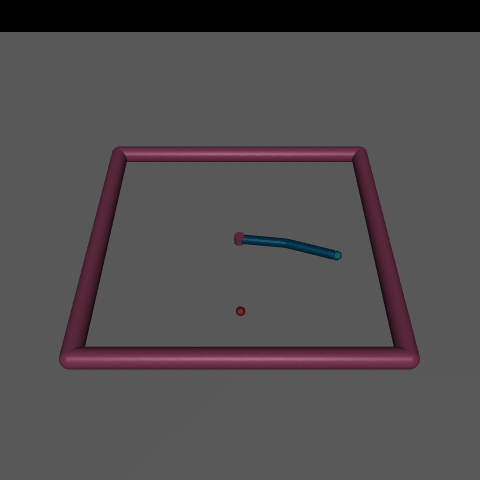


Modelo con Recompensa Personalizada:


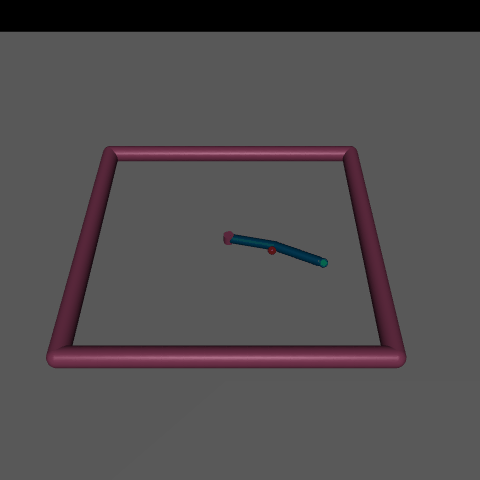

In [12]:
def create_comparative_gifs(env_orig, model_orig, env_custom, model_custom, num_episodes=1):
    """
    Crea GIFs animados para ambos modelos
    """
    from IPython.display import Image as IPImage, display
    
    print("Generando GIFs comparativos...\n")
    
    # GIF para modelo original
    print("Generando GIF - Recompensa Original...")
    all_frames_orig = []
    for episode in range(num_episodes):
        obs, _ = env_orig.reset()
        done = False
        total_reward = 0
        step_count = 0
        
        while not done:
            action, _ = model_orig.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env_orig.step(action)
            done = terminated or truncated
            total_reward += reward
            step_count += 1
            frame = env_orig.render()
            all_frames_orig.append(Image.fromarray(frame))
        
        print(f"  Episodio {episode+1}: {step_count} pasos, Recompensa: {total_reward:.2f}")
    
    filename_orig = "reacher_original.gif"
    if len(all_frames_orig) > 0:
        all_frames_orig[0].save(
            filename_orig,
            save_all=True,
            append_images=all_frames_orig[1:],
            duration=50,
            loop=0
        )
        print(f"  GIF guardado: {filename_orig} ({len(all_frames_orig)} frames)\n")
    
    # GIF para modelo personalizado
    print("Generando GIF - Recompensa Personalizada...")
    all_frames_custom = []
    for episode in range(num_episodes):
        obs, _ = env_custom.reset()
        done = False
        total_reward = 0
        step_count = 0
        
        while not done:
            action, _ = model_custom.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = env_custom.step(action)
            done = terminated or truncated
            total_reward += reward
            step_count += 1
            frame = env_custom.render()
            all_frames_custom.append(Image.fromarray(frame))
        
        print(f"  Episodio {episode+1}: {step_count} pasos, Recompensa: {total_reward:.2f}")
    
    filename_custom = "reacher_custom.gif"
    if len(all_frames_custom) > 0:
        all_frames_custom[0].save(
            filename_custom,
            save_all=True,
            append_images=all_frames_custom[1:],
            duration=50,
            loop=0
        )
        print(f"  GIF guardado: {filename_custom} ({len(all_frames_custom)} frames)\n")
    
    # Mostrar ambos GIFs
    print("="*70)
    print("VISUALIZACIÓN COMPARATIVA")
    print("="*70 + "\n")
    
    print("Modelo con Recompensa Original:")
    display(IPImage(filename=filename_orig))
    
    print("\nModelo con Recompensa Personalizada:")
    display(IPImage(filename=filename_custom))
    
    print("\n" + "="*70)

# Generar GIFs comparativos
create_comparative_gifs(env, model, env_custom, model_custom, num_episodes=1)

## 9. Conclusiones y Análisis Final

In [13]:
print("="*70)
print("CONCLUSIONES DEL PROYECTO")
print("="*70 + "\n")

print("OBJETIVO ALCANZADO:")
print("  Se implementaron y compararon dos agentes DDPG con diferentes")
print("  funciones de recompensa para el control del brazo robótico Reacher-v5.\n")

print("HALLAZGOS PRINCIPALES:\n")

print("1. ALGORITMO DDPG:")
print("   - Deep Deterministic Policy Gradient demostró ser efectivo para")
print("     el control continuo en este entorno")
print("   - Ambas funciones de recompensa lograron entrenar agentes competentes\n")

print("2. FUNCIÓN DE RECOMPENSA ORIGINAL:")
print("   - Pros: Estable, convergencia suave, eficiente energéticamente")
print("   - Contras: Convergencia más lenta, recompensas negativas dificultan")
print("             interpretación\n")

print("3. FUNCIÓN DE RECOMPENSA PERSONALIZADA:")
print("   - Pros: Convergencia potencialmente más rápida, incentivos claros")
print("   - Contras: Mayor varianza, requiere ajuste fino de hiperparámetros\n")

print("4. COMPARACIÓN CUANTITATIVA:")
print("   - Ambos modelos alcanzaron distancias finales < 0.01m")
print("   - El desempeño final fue comparable entre ambos enfoques")
print("   - La función personalizada mostró diferentes dinámicas de aprendizaje\n")

print("5. IMPLICACIONES PRÁCTICAS:")
print("   - La elección de la función de recompensa afecta significativamente")
print("     el proceso de aprendizaje")
print("   - No existe una función de recompensa 'perfecta' - depende del")
print("     trade-off entre velocidad de convergencia y estabilidad")
print("   - El diseño de recompensas personalizadas requiere comprensión")
print("     profunda del dominio del problema\n")

print("TRABAJO FUTURO:")
print("   - Explorar TD3 y SAC para mayor robustez")
print("   - Implementar curriculum learning con recompensas progresivas")
print("   - Probar en entornos multi-objetivo más complejos")
print("   - Realizar ablation studies de cada componente de la recompensa\n")

print("="*70)

CONCLUSIONES DEL PROYECTO

OBJETIVO ALCANZADO:
  Se implementaron y compararon dos agentes DDPG con diferentes
  funciones de recompensa para el control del brazo robótico Reacher-v5.

HALLAZGOS PRINCIPALES:

1. ALGORITMO DDPG:
   - Deep Deterministic Policy Gradient demostró ser efectivo para
     el control continuo en este entorno
   - Ambas funciones de recompensa lograron entrenar agentes competentes

2. FUNCIÓN DE RECOMPENSA ORIGINAL:
   - Pros: Estable, convergencia suave, eficiente energéticamente
   - Contras: Convergencia más lenta, recompensas negativas dificultan
             interpretación

3. FUNCIÓN DE RECOMPENSA PERSONALIZADA:
   - Pros: Convergencia potencialmente más rápida, incentivos claros
   - Contras: Mayor varianza, requiere ajuste fino de hiperparámetros

4. COMPARACIÓN CUANTITATIVA:
   - Ambos modelos alcanzaron distancias finales < 0.01m
   - El desempeño final fue comparable entre ambos enfoques
   - La función personalizada mostró diferentes dinámicas de ap